In [ ]:
!pip install pycryptodome opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.6 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from base64 import b64encode, b64decode
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from google.colab import files
from datetime import datetime

In [ ]:
# Create output directory
output_dir = "stego_output"
os.makedirs(output_dir, exist_ok=True)

# AES Encryption
def encrypt_message(message, key):
    key = key.ljust(16)[:16].encode()  # Pad or truncate key to 16 bytes
    cipher = AES.new(key, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    return b64encode(cipher.iv + ct_bytes)

# AES Decryption
def decrypt_message(cipher_text_b64, key):
    key = key.ljust(16)[:16].encode()
    raw = b64decode(cipher_text_b64)
    iv = raw[:16]
    ct = raw[16:]
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return unpad(cipher.decrypt(ct), AES.block_size).decode()

# Convert string/bytes to binary string
def to_bin(data):
    if isinstance(data, bytes):
        return ''.join(format(byte, '08b') for byte in data)
    elif isinstance(data, str):
        return ''.join(format(ord(char), '08b') for char in data)
    else:
        raise TypeError("Input must be bytes or string")

In [ ]:
def encode_image(image_path, encrypted_data):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Image not found.")

    binary_data = to_bin(encrypted_data)
    data_len = len(binary_data)
    data_idx = 0

    encoded_img = img.copy()
    rows, cols, _ = img.shape

    for row in range(rows):
        for col in range(cols):
            pixel = encoded_img[row, col]
            for n in range(3):  # B, G, R
                if data_idx < data_len:
                    pixel[n] = (int(pixel[n]) & ~1) | int(binary_data[data_idx])
                    data_idx += 1
            encoded_img[row, col] = pixel
            if data_idx >= data_len:
                break
        if data_idx >= data_len:
            break

    if data_idx < data_len:
        raise ValueError("Image too small to hold the full message.")

    return encoded_img

# Save image to file
def save_encoded_image(image_data):
    filename = f"{output_dir}/encoded_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    cv2.imwrite(filename, image_data)
    return filename

In [ ]:
def decode_image(image_path, key):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Image not found.")

    binary_data = ""
    for row in img:
        for pixel in row:
            for n in range(3):
                binary_data += str(pixel[n] & 1)

    all_bytes = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    message_bytes = bytearray()

    for byte in all_bytes:
        message_bytes.append(int(byte, 2))
        try:
            decrypted = decrypt_message(bytes(message_bytes), key)
            return decrypted
        except:
            continue

    return "[Decryption Failed: Invalid key or corrupted data]"

🔐 Enter the secret message: Secret Message 
🔑 Enter a 16-character encryption key: Hello World
📁 Upload an image file (.png or .jpg):


Saving Dhoni.webp to Dhoni (2).webp


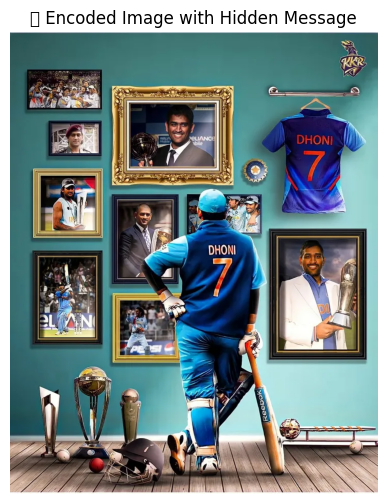

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔐 Input secret message and key
secret_msg = input("🔐 Enter the secret message: ")
aes_key = input("🔑 Enter a 16-character encryption key: ")

# 📷 Upload image
print("📁 Upload an image file (.png or .jpg):")
uploaded = files.upload()
image_filename = next(iter(uploaded))

# 🔒 Encrypt and Encode
encrypted_msg = encrypt_message(secret_msg, aes_key)
encoded_image = encode_image(image_filename, encrypted_msg)
output_file = save_encoded_image(encoded_image)

# ✅ Show encoded image
encoded_img_rgb = cv2.cvtColor(encoded_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(encoded_img_rgb)
plt.title("🖼️ Encoded Image with Hidden Message")
plt.axis('off')
plt.show()

# 📥 Download encoded image
files.download(output_file)

In [ ]:
# 🔓 Decode and Decrypt
def decode_image(image_path, key, max_bytes=2048):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Image not found.")

    binary_data = ""
    rows, cols, _ = img.shape
    total_pixels = rows * cols * 3  # B, G, R channels

    for row in img:
        for pixel in row:
            for n in range(3):
                binary_data += str(pixel[n] & 1)
                if len(binary_data) >= max_bytes * 8:
                    break
            if len(binary_data) >= max_bytes * 8:
                break
        if len(binary_data) >= max_bytes * 8:
            break

    all_bytes = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    message_bytes = bytearray()
    for byte in all_bytes:
        message_bytes.append(int(byte, 2))

    try:
        # Try decryption
        decrypted = decrypt_message(bytes(message_bytes), key)
        return decrypted
    except Exception as e:
        return f"[❌ Decryption Failed] - {str(e)}"
print("📁 Upload the encoded image to decode:")
uploaded_dec = files.upload()
decode_img_path = next(iter(uploaded_dec))

key_for_decrypt = input("🔑 Enter the encryption key used during encoding: ")
decoded_message = decode_image(decode_img_path, key_for_decrypt)

print("\n📤 Decoded Secret Message:", decoded_message)

📁 Upload the encoded image to decode:


Saving encoded_20250618_160346.png to encoded_20250618_160346.png
🔑 Enter the encryption key used during encoding: Hello World 

📤 Decoded Secret Message: Secret Message 
